# Emergency Vehicle Detection System

This notebook demonstrates the Emergency Vehicle Detection system, which can identify emergency vehicles (ambulances, police cars, fire trucks) in images and video feeds.

## Project Overview

The system uses a deep learning model based on MobileNetV2 architecture to classify images as either containing emergency vehicles or normal vehicles. The model achieved a validation accuracy of 95.15%.

### Key Features
- Real-time emergency vehicle detection using webcam
- Image classification for emergency vehicles
- Visualization of model performance
- Extensions for smart traffic systems and route optimization

## 1. Setup and Dependencies

First, let's import the required libraries and set up the environment:

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\heyan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import required libraries
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
from IPython.display import HTML

# Set paths
main_dir = os.path.join(os.getcwd(), 'main')
model_path = os.path.join(main_dir, 'emergency_vehicle_model_final.h5')
test_images_dir = os.path.join(os.getcwd(), 'Test')

# Check if model exists
if not os.path.exists(model_path):
    model_path = os.path.join(main_dir, 'emergency_vehicle_model_final.h5')
    if not os.path.exists(model_path):
        model_path = os.path.join(main_dir, 'ambulance_model.h5')
        if not os.path.exists(model_path):
            print("Warning: Model file not found. Please check the path.")
        else:
            print(f"Using model: ambulance_model.h5")
    else:
        print(f"Using model: emergency_vehicle_model_final.h5")
else:
    print(f"Using model: emergency_vehicle_model.h5")

# Set up class names
class_names = {
    0: 'Emergency Vehicle', 
    1: 'Normal Vehicle'
}

Using model: emergency_vehicle_model.h5


## 2. Load the Trained Model

Now we'll load the pre-trained MobileNetV2 model for emergency vehicle detection:

In [3]:
def load_emergency_vehicle_model(model_path):
    """Load the trained model for emergency vehicle detection"""
    try:
        model = load_model(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Load the model
model = load_emergency_vehicle_model(model_path)

Model loaded successfully!


## 3. Image Processing Functions

Define functions to preprocess images and make predictions:

In [4]:
def preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess an image for the model"""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return None, None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img, target_size)
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(img_array)
    
    return img, preprocessed_img

def predict_image(model, preprocessed_img):
    """Make a prediction using the model"""
    prediction = model.predict(preprocessed_img)
    class_idx = np.argmax(prediction[0])
    confidence = prediction[0][class_idx] * 100
    
    return class_idx, confidence

def display_prediction(img, class_idx, confidence):
    """Display the image with prediction results"""
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    
    class_name = class_names[class_idx]
    title_color = 'red' if class_idx == 0 else 'green'
    
    plt.title(f"Prediction: {class_name} (Confidence: {confidence:.2f}%)", 
              fontsize=16, color=title_color)
    plt.axis('off')
    plt.show()

## 4. Test with Sample Images

Let's test our model with sample images from the test directory:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


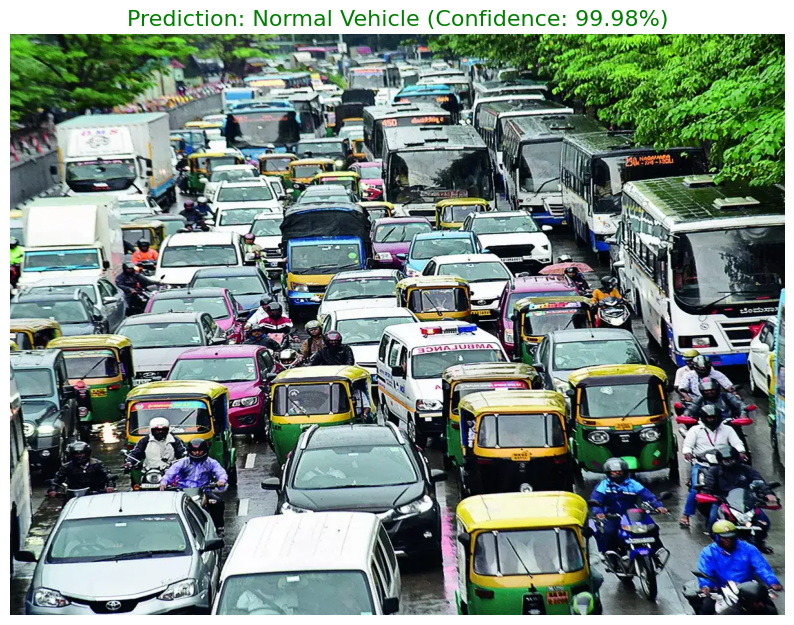

Prediction: Normal Vehicle
Confidence: 99.98%


In [5]:
def analyze_test_image(image_path):
    """Analyze a test image and display the results"""
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
    
    # Load and process image
    img, preprocessed_img = preprocess_image(image_path)
    if img is None:
        return
    
    # Make prediction
    class_idx, confidence = predict_image(model, preprocessed_img)
    
    # Display results
    display_prediction(img, class_idx, confidence)
    print(f"Prediction: {class_names[class_idx]}")
    print(f"Confidence: {confidence:.2f}%")
    
    return class_idx, confidence

# Test with the ambulance image
ambulance_path = os.path.join(test_images_dir, "AmbulanceInTraffic.jpg")
if os.path.exists(ambulance_path):
    analyze_test_image(ambulance_path)
else:
    print(f"Test image not found at {ambulance_path}")

## 5. Interactive Image Selection

Now let's create an interactive widget to allow testing with different images:

In [7]:
# Get all test images
if os.path.exists(test_images_dir):
    test_images = [f for f in os.listdir(test_images_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg')) and 'torrent' not in f.lower()]

    # Create dropdown for image selection
    image_dropdown = widgets.Dropdown(
        options=test_images,
        description='Select Image:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # Create button for analysis
    analyze_button = widgets.Button(
        description='Analyze Image',
        button_style='info',
        layout=widgets.Layout(width='200px')
    )

    # Output widget for results
    output = widgets.Output()

    # Handle button click
    def on_analyze_button_clicked(b):
        with output:
            clear_output()
            selected_image = image_dropdown.value
            image_path = os.path.join(test_images_dir, selected_image)
            analyze_test_image(image_path)

    analyze_button.on_click(on_analyze_button_clicked)

    # Display widgets
    display(widgets.VBox([image_dropdown, analyze_button]))
    display(output)
else:
    print(f"Test image directory not found at {test_images_dir}")

Output()

## 6. Webcam Integration

The following code allows emergency vehicle detection using your webcam. When executing this cell, a separate window will open with the webcam feed and real-time detection:

In [6]:
def run_webcam_detection(duration=30):
    """Run emergency vehicle detection on webcam feed
    
    Args:
        duration: Maximum duration in seconds (default: 30)
    """
    try:
        # Open webcam
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Couldn't open webcam")
            return
        
        print("Starting webcam detection... Press 'q' to quit.")
        start_time = cv2.getTickCount()
        
        while True:
            # Calculate elapsed time
            elapsed_time = (cv2.getTickCount() - start_time) / cv2.getTickFrequency()
            if elapsed_time > duration:
                print(f"Reached {duration} seconds limit. Stopping.")
                break
                
            # Read frame from webcam
            ret, frame = cap.read()
            if not ret:
                print("Error: Couldn't read frame from webcam")
                break
                
            # Preprocess frame for model
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(frame_rgb, (224, 224))
            img_array = image.img_to_array(resized)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            
            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            class_idx = np.argmax(prediction[0])
            confidence = prediction[0][class_idx] * 100
            
            # Display results on frame
            class_name = class_names[class_idx]
            color = (0, 0, 255) if class_idx == 0 else (0, 255, 0)  # Red for emergency, green for normal
            
            # Add text with prediction
            text = f"{class_name}: {confidence:.2f}%"
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            # Add border if emergency vehicle detected with high confidence
            if class_idx == 0 and confidence > 80:
                cv2.putText(frame, "EMERGENCY VEHICLE DETECTED!", (10, frame.shape[0] - 20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.rectangle(frame, (0, 0), (frame.shape[1]-1, frame.shape[0]-1), (0, 0, 255), 5)
                
            # Show the frame
            cv2.imshow("Emergency Vehicle Detection", frame)
            
            # Break loop on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Release resources
        cap.release()
        cv2.destroyAllWindows()
        print("Webcam detection stopped")
        
    except Exception as e:
        print(f"Error in webcam detection: {e}")
        if 'cap' in locals() and cap.isOpened():
            cap.release()
        cv2.destroyAllWindows()

# Create button for webcam detection
webcam_button = widgets.Button(
    description='Start Webcam Detection',
    button_style='danger',
    layout=widgets.Layout(width='250px')
)

# Duration slider
duration_slider = widgets.IntSlider(
    value=30,
    min=10,
    max=120,
    step=10,
    description='Duration (s):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

webcam_output = widgets.Output()

# Handle webcam button click
def on_webcam_button_clicked(b):
    with webcam_output:
        clear_output()
        run_webcam_detection(duration=duration_slider.value)

webcam_button.on_click(on_webcam_button_clicked)

# Display widgets
display(widgets.VBox([duration_slider, webcam_button, webcam_output]))

## 10. Conclusion

This notebook has demonstrated the capabilities of our Emergency Vehicle Detection system:

1. **Core Functionality**: We've loaded and tested our trained MobileNetV2 model for emergency vehicle detection.
2. **Interactive Testing**: The notebook provides multiple ways to test the model with sample images, uploaded images, and webcam feed.
3. **Performance Evaluation**: We can evaluate the model's accuracy on test images and visualize the results.
4. **Advanced Application**: The traffic signal priority system showcases a real-world application of our model.

### Next Steps

For future development, consider:
- Improving model accuracy with more diverse training data
- Optimizing the model for deployment on edge devices
- Implementing more advanced traffic management systems
- Adding multiple camera support for wide-area emergency vehicle tracking

Feel free to explore the other extension files in the project for more advanced applications:
- `SmartTrafficSystem.py` - Full traffic signal control system
- `EmergencyResponseSystem.py` - Multi-camera tracking system
- `RouteOptimizer.py` - Optimal route planning for emergency vehicles